### Running conditional when another script is busy

In [ ]:
phenotype <- 'CD'
downsampling <- TRUE
downsampling_size <- 300
hla_genes <- c('DQB1', 'DQA1', 'B', 'DPB1', 'DPA1', 'A', 'C')
hla_gene <- 'B'
cond_round <- 2
using_groups <- FALSE
source('/work_beegfs/sukmb667/projects/cdr3-qtl/healthy_and_ibd/scripts/R_scripts/Conditional_haplotype_on_combined_IKMB_data.r')

In [ ]:
manova_cond

Res.Df,Df,Gen.var.,Pillai,approx F,num Df,den Df,Pvalue,Omnibus,model,P_val,variance_explained,pair,condition,Length_cdr3,IMGT
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
289,NA,0.7261073,NA,NA,NA,NA,NA,0.06354671,null,2.848055e-12,0.009337201,L12_P108,156_199_46_103,L12,P108
285,-4,0.7291328,0.1896801,0.6695493,80,1076,0.9881963,0.07288391,full,9.735200e-09,0.009337201,L12_P108,156_199_46_103,L12,P108


In [ ]:
fread('/work_beegfs/sukmb667/projects/cdr3-qtl/healthy_and_ibd/conditional_analysis/UC/B_conditional_round_2.tsv', sep = '\t') %>% define_cond_hits()
fread('/work_beegfs/sukmb667/projects/cdr3-qtl/healthy_and_ibd/conditional_analysis/CD/downsampled/B_conditional_round_3.tsv', sep = '\t') %>% define_cond_hits()
fread('/work_beegfs/sukmb667/projects/cdr3-qtl/healthy_and_ibd/conditional_analysis/CD/B_conditional_round_3.tsv', sep = '\t') %>% define_cond_hits()

$L12
[1] "156" "80" 

$L13
[1] "156" "167"

$L14
[1] "156" "80" 

$L15
[1] "156" "80" 

$L16
[1] "156" "80" 

$L17
[1] "156" "177"

In [1]:
source('/work_beegfs/sukmb667/projects/cdr3-qtl/healthy_and_ibd/scripts/libraries_analysis.R')
source('/work_beegfs/sukmb667/projects/cdr3-qtl/healthy_and_ibd/scripts/R_functions/cdr3-QTL_functions.R')
source('/work_beegfs/sukmb667/projects/cdr3-qtl/healthy_and_ibd/scripts/R_functions/hla_functions.R')


Attaching package: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘tidyr’


The following object is masked from ‘package:magrittr’:

    extract


Loading required package: ggplot2

Loading required package: lattice


Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths


The following objects are masked from ‘package:data.table’:

    dcast, melt



---------------------
Welcome to dendextend version 1.17.1
Type citation('dendextend') for how to cite the package.

Type browseVignettes(package = 'dendextend') for the package vignette.
The github page is: https://github.com/talgalili/dendextend/

Suggestions and bug-reports can be submitted at: https://github.com/talgalili/dendextend/issues
You may ask qu

### Main Manova 3PCs and removing corr > 0.5 HLA alleles from PCA


### updated version in 30.10.24

#### preparing cdr3-hla-matrices as in Ishigaki

In [5]:
hla_genotypes_matrix_wo_low_ab <- fread('../data/hla/hla_genotypes_matrix_wo_low_ab.csv')
pca_hla <- pca_hla_fun(hla_genotypes_matrix_wo_low_ab, 0.5, 3)
fwrite(pca_hla, '../data/hla/pca_hla_as_Ishigaki.tsv', sep = '\t')

In [12]:
dir_pair_path <- paste0('../cdr3_hla_pairs/as_in_Ishigaki/')
hla_matrices <- paste0('../hla_matrices_v3/all/',list.files('../hla_matrices_v3/all/'))
files_group <- paste0('../cdr3_hla_pairs//CDR3_GROUPS_IRT/', list.files('../cdr3_hla_pairs//CDR3_GROUPS_IRT/')) 

prep_mode <- c('irt_freq_unique')

for (L_P_group in files_group){

    cdr3_L_P <- fread(L_P_group)
   
    L <- unique(cdr3_L_P$length_seq)
    P <- unique(cdr3_L_P$IMGT)
        
    cdr3_matrix <- dcast(cdr3_L_P, patient_id ~ AA, value.var = prep_mode)
            
        for (f in hla_matrices){
            
            hla_matrix <- fread(f) %>% left_join(pca_hla, by = 'patient_id')
            hla_matrix$G_S <- gsub(':', '_', hla_matrix$G_S)
            new_path <- gsub('/all/', '/as_in_Ishigaki/', f)
            fwrite(hla_matrix, new_path)
            
            cdr3_hla_matrix <- merge(hla_matrix, cdr3_matrix, by = 'patient_id', all.x = TRUE)
            cdr3_hla_matrix$pair <- paste0(hla_matrix$G_S[1],'_', L, '_', P)
            name_pair <- cdr3_hla_matrix$pair[1]
    
            cdr3_hla_matrix[, G_S := NULL]
            fwrite(cdr3_hla_matrix, paste0(dir_pair_path,name_pair,'_matrix.tsv'), sep = '\t')
            
        }
        }



### Main Manova as in Ishigaki

In [ ]:
pairs <- '../cdr3_hla_pairs/as_in_Ishigaki/'
dir_pair_path <- paste0(pairs, list.files(pairs))
dir_results <- '../manova_results_v3/as_in_Ishigaki_removing_90_correlated/'
if (!file.exists(dir_results)) {
    dir.create(dir_results, recursive = TRUE)
    }
pcs <- 3

first <- TRUE
for (f in dir_pair_path){
    
    cdr3_hla_matrix <- na.omit(fread(f)) 
    name_pair <- cdr3_hla_matrix$pair[1]
    
    manova_df <- mlm_fun(cdr3_hla_matrix, dir_results, n_pcs = pcs)
    if (first){
        manova_df_all <- manova_df[0,]
        first <- FALSE
    }
    if (is.null(manova_df)){
        next
    } else {
        manova_df_all <- rbind(manova_df_all, manova_df) 
        }
    }

manova_df_all <- manova_df_all %>% separate(pair, into = c('HLA', 'Site_hla', 'Length_cdr3', 'Position_cdr3'), sep = '_', remove = FALSE)
fwrite(manova_df_all, paste0(dir_results, '../main_manova_as_in_Ishigaki_removing_90_corr.tsv'), sep = '\t')

Warning message in CompQuadForm::davies(0, lambda = gamma, h = nu, lim = lim, acc = acc):
“Consider playing with 'lim' or 'acc'.”
Warning message in CompQuadForm::davies(0, lambda = gamma, h = nu, lim = lim, acc = acc):
“Consider playing with 'lim' or 'acc'.”
Warning message in CompQuadForm::davies(0, lambda = gamma, h = nu, lim = lim, acc = acc):
“Consider playing with 'lim' or 'acc'.”
Warning message in CompQuadForm::davies(0, lambda = gamma, h = nu, lim = lim, acc = acc):
“Consider playing with 'lim' or 'acc'.”
Warning message in CompQuadForm::davies(0, lambda = gamma, h = nu, lim = lim, acc = acc):
“Consider playing with 'lim' or 'acc'.”
Warning message in CompQuadForm::davies(0, lambda = gamma, h = nu, lim = lim, acc = acc):
“Consider playing with 'lim' or 'acc'.”
Warning message in CompQuadForm::davies(0, lambda = gamma, h = nu, lim = lim, acc = acc):
“Consider playing with 'lim' or 'acc'.”
Warning message in CompQuadForm::davies(0, lambda = gamma, h = nu, lim = lim, acc = acc):


### Preparing pairs for HEALTHY with genomic PCs

In [73]:
genomic_pcs <- fread('../data/genome_wide_PCAs_for_healthy_controls.tsv')
genomic_pcs <- rename(genomic_pcs, patient_id = sample_name)
genomic_pcs$patient_id <- gsub('sample_', 'H', genomic_pcs$patient_id)
head(genomic_pcs)

patient_id,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
H0,-0.015185220,0.0002992094,-0.011055930,-0.005182404,-0.014665780,-0.019234530,0.005770355,0.006256476,-0.003214992
H1,0.001495057,0.0064960430,0.006318532,0.014551140,-0.005667880,0.002744320,0.004658731,0.012901230,0.005201625
H2,-0.002984845,0.0070417280,0.001877927,0.011139590,0.002435838,-0.003853856,-0.005456175,-0.017193080,-0.009583392
H3,-0.033385100,-0.0122756800,-0.019726040,0.019799460,0.001699981,-0.007106367,0.002553050,-0.007577566,-0.004764016
H4,0.003662524,0.0537351300,0.007162315,-0.013213600,0.011220510,-0.003600613,-0.004232726,0.004641246,-0.009943161
H5,-0.007231236,0.0255026400,-0.009406079,-0.007835455,0.007923224,-0.008923012,-0.005096819,-0.005450787,-0.005516485


In [75]:
norm_freq_pairs <- paste0('../cdr3_hla_pairs/norm_freq_unique/', list.files('../cdr3_hla_pairs/norm_freq_unique/'))

In [87]:
colnames(genomic_pcs) <- gsub('PC', 'genomic_PC', colnames(genomic_pcs))

In [89]:
for (f in norm_freq_pairs){
    cdr3_hla_matrix <- fread(f)
    new_genomic <-  cdr3_hla_matrix %>% merge(genomic_pcs, all.y = TRUE) %>% na.omit()
    fwrite(new_genomic, gsub('cdr3_hla_pairs', 'HEALTHY', f), sep = '\t')
}

### MANOVA with HLA_PCs vs Genomic PCs

In [3]:
source('libraries.R')
source('R_functions/hla_functions.R')


Attaching package: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘tidyr’


The following object is masked from ‘package:magrittr’:

    extract


Registered S3 methods overwritten by 'ggtern':
  method           from   
  grid.draw.ggplot ggplot2
  plot.ggplot      ggplot2
  print.ggplot     ggplot2

--
Remember to cite, run citation(package = 'ggtern') for further info.
--


Attaching package: ‘ggtern’


The following objects are masked from ‘package:ggplot2’:

    aes, annotate, ggplot, ggplot_build, ggplot_gtable, ggplotGrob,
    ggsave, layer_data, theme_bw, theme_classic, theme_dark,
    theme_gray, theme_light, theme_linedraw, theme_minimal, theme_void


Loading required package: viridisLite


Attaching package: ‘arrow’


The following obje

In [5]:
cdr3_hla_matrix <- fread('../HEALTHY//norm_freq_unique/DRB1_13_13_P109.tsv')
n_pcs <- 3
bonf <- 0.0001/nrow(cdr3_hla_matrix)
amino_acids <-c('A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y') 
name_pair <- unique(cdr3_hla_matrix$pair)
without_ref_allele <- cdr3_hla_matrix %>% 
    summarise(across(contains('allele'), sum)) %>% t() %>% as.data.frame() %>% 
    arrange(desc(V1)) %>% slice(-1) %>% rownames()

tryCatch({
    if (length(without_ref_allele)>=2){
        hla_alleles <- colnames(remove_correlated_columns(cdr3_hla_matrix %>% dplyr::select(all_of(without_ref_allele)), 0.9))
    }else{
        hla_alleles <- colnames(cdr3_hla_matrix %>% dplyr::select(all_of(without_ref_allele)))
    } 
    }, 
    error = function(e) {
    message("Error: ", e)
    },
    finally = {
        if (!exists('hla_alleles')){
            hla_alleles <- colnames(cdr3_hla_matrix %>% dplyr::select(all_of(without_ref_allele)))}
        
    })

if (length(colnames(cdr3_hla_matrix)[colnames(cdr3_hla_matrix) %in% amino_acids]) > 1){
    
    aa_in_matrix <- paste0(colnames(cdr3_hla_matrix)[colnames(cdr3_hla_matrix) %in% amino_acids], collapse = ',')
    Y <- paste0('cbind(',aa_in_matrix,') ~')
    X <- paste0(hla_alleles,  collapse = '+')
    PCs <- paste0('PC', seq(1,n_pcs), collapse = '+')
    genomic_PCs <- paste0('genomic_PC', seq(1,n_pcs), collapse = '+')
   
    formula_full <- as.formula(str_c(paste0(Y,X),PCs, sep   = '+'))
    formula_full_genomic <- as.formula(str_c(paste0(Y,X),genomic_PCs, sep   = '+'))
    formula_null <- as.formula(str_c(Y,PCs))
    formula_null_genomic <- as.formula(str_c(Y,genomic_PCs))
    }
mod1 <- lm(formula_full, data = cdr3_hla_matrix)
mod1_gen <- lm(formula_full_genomic, data = cdr3_hla_matrix)
mod0 <- lm(formula_null, data = cdr3_hla_matrix)
mod0_gen <- lm(formula_null_genomic, data = cdr3_hla_matrix)

In [116]:
AIC(lm(cdr3_pc1 ~ allele_R + allele_H + allele_F + allele_Y + allele_G + PC1 + PC2 + PC3, data = cdr3_hla_matrix) )
AIC(lm(cdr3_pc1 ~ allele_R + allele_H + allele_F + allele_Y + allele_G + genomic_PC1 + genomic_PC2 + genomic_PC3, data = cdr3_hla_matrix) )

[1] 2978.059

[1] 3003.97

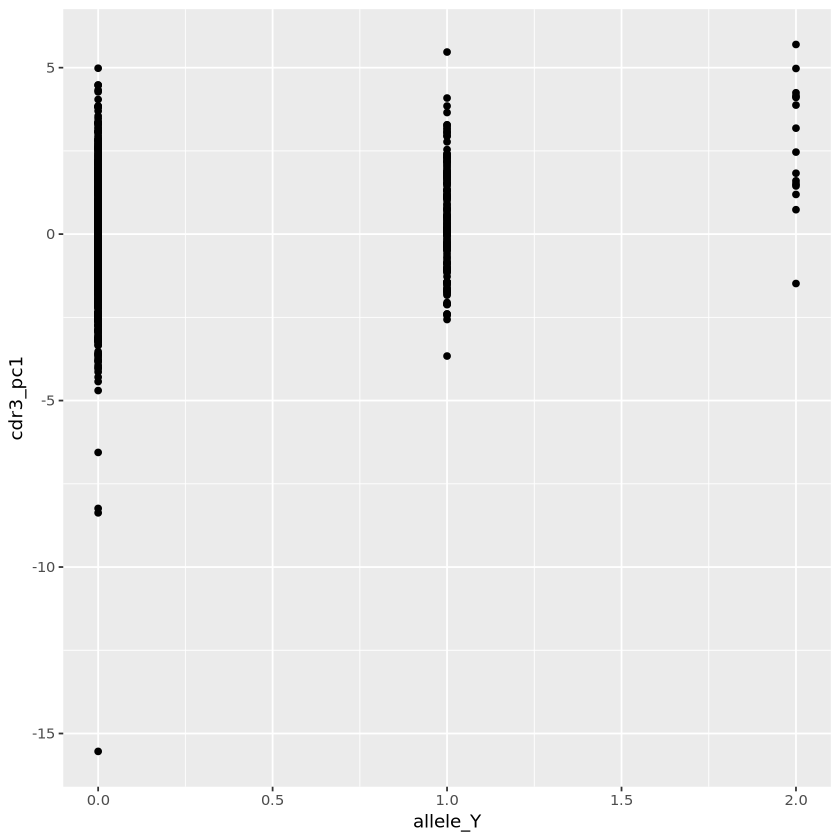

In [119]:
ggplot(cdr3_hla_matrix, aes(y = cdr3_pc1, x = allele_Y)) +
    geom_point()

### PERMANOVA with groups

In [ ]:
source('/work_beegfs/sukmb667/projects/cdr3-qtl/healthy_and_ibd/scripts/libraries_analysis.R')
source('/work_beegfs/sukmb667/projects/cdr3-qtl/healthy_and_ibd/scripts/R_functions/cdr3-QTL_functions.R')
source('/work_beegfs/sukmb667/projects/cdr3-qtl/healthy_and_ibd/scripts/R_functions/hla_functions.R')

#### The first round of PERMANOVA

In [ ]:
phenotype <- 'both'
hla_gene <- 'DRB1'
cond_round <- 0
source("/work_beegfs/sukmb667/projects/cdr3-qtl/healthy_and_ibd/scripts/R_scripts/Conditional_haplotype_with_PERMANOVA.r")

In [497]:
permanova_dt_all

Df,SumOfSqs,R2,F,Pr(>F),Site_hla,aic,variance_explained
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
2,5.419520,0.0008072159,0.6786091,0.8989051,null,2333.243,0.0008072159
4,10.033317,0.0015015940,0.6278583,0.9862507,10,2325.000,0.0015015940
3,8.228914,0.0012315457,0.6868168,0.9403530,104,2323.441,0.0012315457


In [51]:
significant_hits <- define_cond_hits(permanova_dt_all, 1)
significant_hits
hla_reduced <- sites_recategorate(hla_alleles_patients, site_matrix(significant_hits))
x_reduced_alleles <- colnames(hla_reduced)[-1]

hla_var_sites_to_test <- hla_var_sites[!(hla_var_sites %in% significant_hits)]
combinations_to_test <- lapply(hla_var_sites_to_test, function(x) c(significant_hits,x))
combinations_to_test

[1] "10"  "104" "11"  "12"  "120" "13"  "133" "14"  "140" "142" "149" "16" 
[13] "180" "181" "233" "25"  "26"  "28"  "30"  "31"  "32"  "33"  "37"  "4"  
[25] "47"  "57"  "58"  "60"  "67"  "70"  "71"  "73"  "74"  "77"  "78"  "86" 
[37] "9"   "96"  "98"

In [48]:
first <- TRUE
for (j in seq_along(combinations_to_test)){
    sites <- combinations_to_test[[j]]
    cond <- paste(sites, collapse = '_')
    site_comb <- site_matrix(sites)
    conditional_matrix <- sites_recategorate(hla_alleles_patients, site_comb)
    cond_covariates <- colnames(conditional_matrix)[-1]

    cdr3_matrix <- merge(dt, hla_reduced, by = 'patient_id')
    test <- merge(cdr3_matrix, conditional_matrix, by = 'patient_id')
    permanova_dt <- permanova_fun(test, cond_covariates, x_reduced_alleles, n_permut = 9999)
    permanova_dt$condition <- cond
    if (first){
        permanova_dt_all <- permanova_dt
        first <- FALSE
    } else {
        permanova_dt_all <- rbind(permanova_dt_all, permanova_dt)
    }
    
} 
fwrite(permanova_dt_all, '/work_beegfs/sukmb667/projects/cdr3-qtl/healthy_and_ibd/conditional_analysis//permanova_drb1_round1.tsv', sep = '\t')

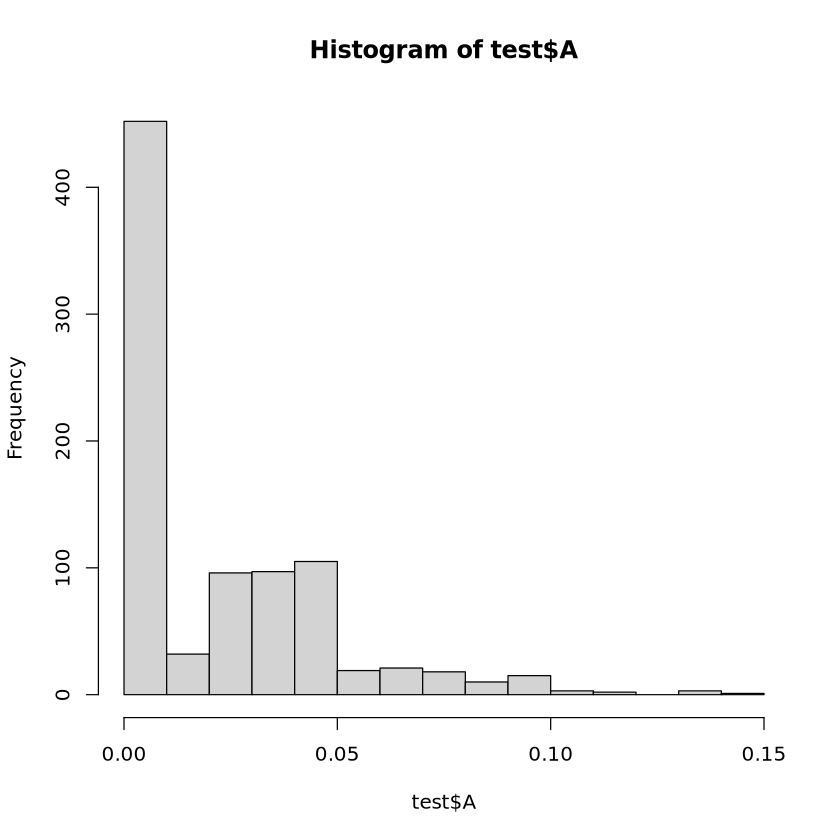

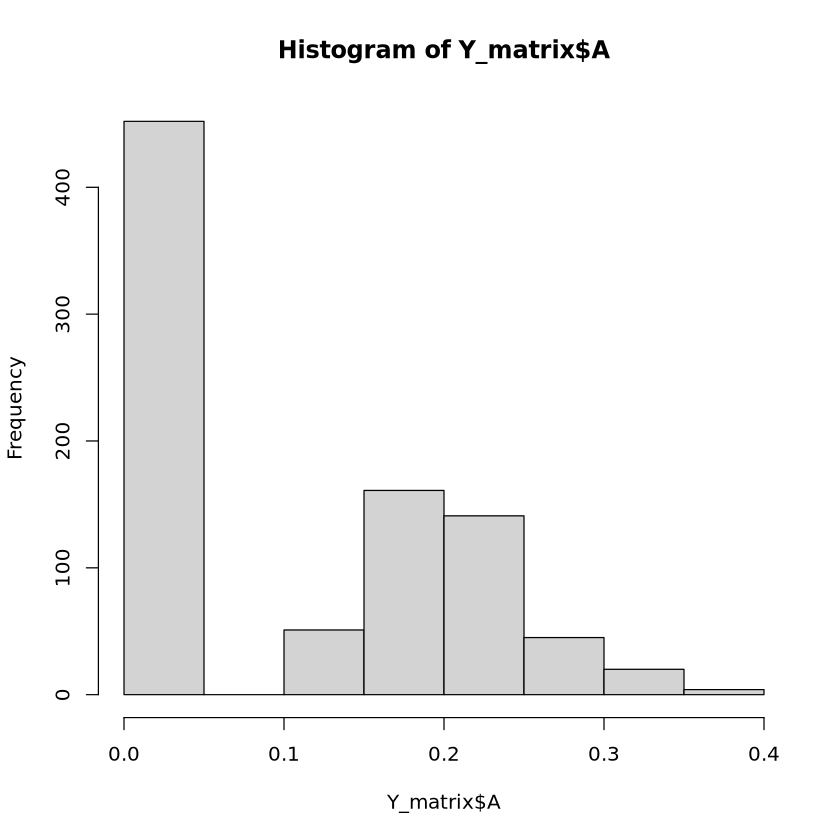

In [122]:
test <- cdr3_hla_matrix %>% dplyr::select(all_of(aa_in_matrix))
hist(test$A)
hist(Y_matrix$A)

In [46]:
permod0
permod1

,Df,SumOfSqs,R2,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Model,5,0.4834196,0.005541183,0.9673093,0.493
Residual,868,86.7578183,0.994458817,NA,NA
Total,873,87.2412380,1.000000000,NA,NA


,Df,SumOfSqs,R2,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Model,3,0.03753383,0.002093121,1.341009,0.081
Residual,1918,17.89445652,0.997906879,NA,NA
Total,1921,17.93199035,1.000000000,NA,NA


In [29]:
AICc_permanova2(permod1)
#AICc_permanova2(permod1_gen)
AICc_permanova2(permod0)
#AICc_permanova2(permod0_gen)

AICc,k,N
<dbl>,<dbl>,<dbl>
-2005.517,7,874


AICc,k,N
<dbl>,<dbl>,<dbl>
-2006.808,6,874


In [130]:
permod0_gen
permod1_gen

,Df,SumOfSqs,R2,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Model,3,0.002868039,0.007081379,1.749688,0.023
Residual,736,0.402143382,0.992918621,NA,NA
Total,739,0.405011422,1.000000000,NA,NA


,Df,SumOfSqs,R2,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Model,8,0.06938908,0.1713262,18.89155,0.001
Residual,731,0.33562234,0.8286738,NA,NA
Total,739,0.40501142,1.0000000,NA,NA


### Comparing CDR3 composition with different length

In [ ]:
cdr3_lengths <- list.files('../data/CDR3_GROUPS_FREQ/')
cdr3_lengths_to_test <- cdr3_lengths[!grepl(paste(c('P104', 'P105', 'P117', 'P118'), collapse = "|"), cdr3_lengths)]

In [5]:
first <- TRUE
for (f in cdr3_lengths_to_test){
    test <- fread(paste0('../data/CDR3_GROUPS_FREQ/', f))
    cdr3_matrix <- dcast(test, patient_id  ~ AA, value.var =  'norm_freq_unique')
    cdr3_matrix$group <- gsub( '.tsv', '', f)
    if (first){
        cdr3_matrices <- cdr3_matrix
        first <- FALSE
    } else{
        cdr3_matrices <- rbindlist(list(cdr3_matrices, cdr3_matrix), fill = TRUE)
    }
    }
cdr3_matrices[is.na(cdr3_matrices)] <- 0
cdr3_matrices <- cdr3_matrices[, c('length_seq', 'IMGT') := tstrsplit(group, '_')]


In [10]:
h0 <- cdr3_matrices#[patient_id == 'H1']
Y_matrix <- vegdist(h0 %>% dplyr::select(any_of(aa_in_matrix)))
cdr3_comp_model <- adonis2(Y_matrix ~ length_seq, h0, permutations = 999, parallel = 5)
cdr3_comp_model

Warning message in vegdist(as.matrix(lhs), method = method, ...):
“you have empty rows: their dissimilarities may be
                 meaningless in method “bray””


In [214]:

library(pairwiseAdonis)

dist_matrix <- dist(h0[,2:20])  # Euclidean distance matrix
group <- test$length_seq            # Grouping variable

# Perform pairwise PERMANOVA
pairwise_results <- pairwise.adonis(dist_matrix, group)

# View results
print(pairwise_results)

ERROR: Error in combn(unique(as.character(factors)), 2): n < m


### PERMANOVA vs Random Forests

In [86]:
cdr3_hla_matrix <- fread('../HEALTHY//norm_freq_unique/DRB1_13_13_P109.tsv')
X_matrix <- cdr3_hla_matrix %>% dplyr::select(!any_of(aa_in_matrix)) %>% dplyr::select(-c(group, pair))
cdr3_pcs <- prcomp(Y_matrix, scale. = TRUE)
cdr3_hla_matrix$cdr3_pc1 <- cdr3_pcs$x[,1]

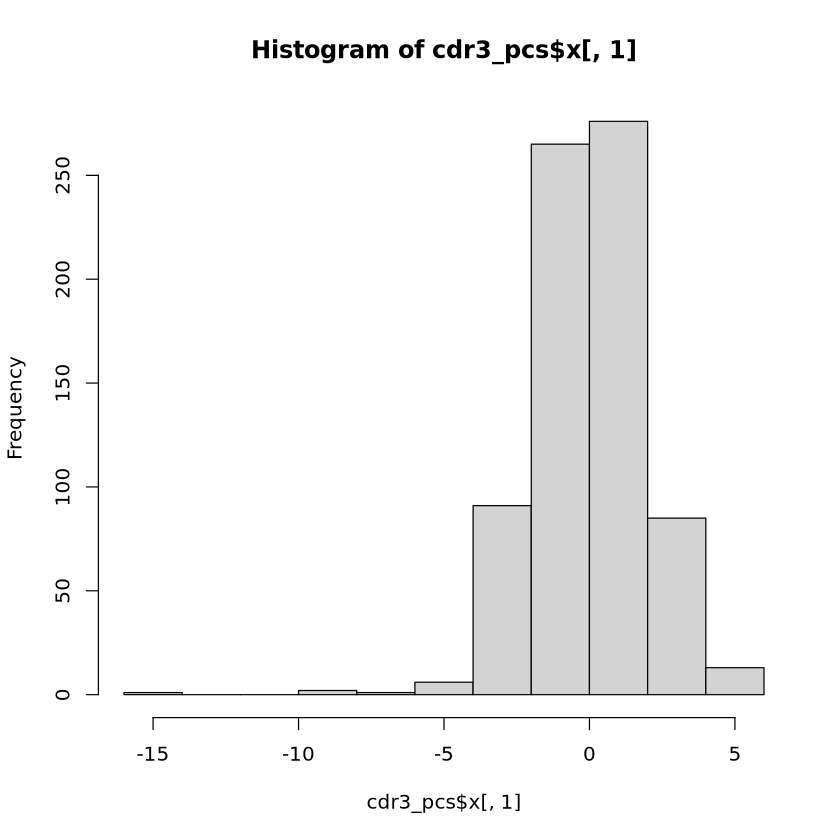

In [54]:
hist(cdr3_pcs$x[,1])

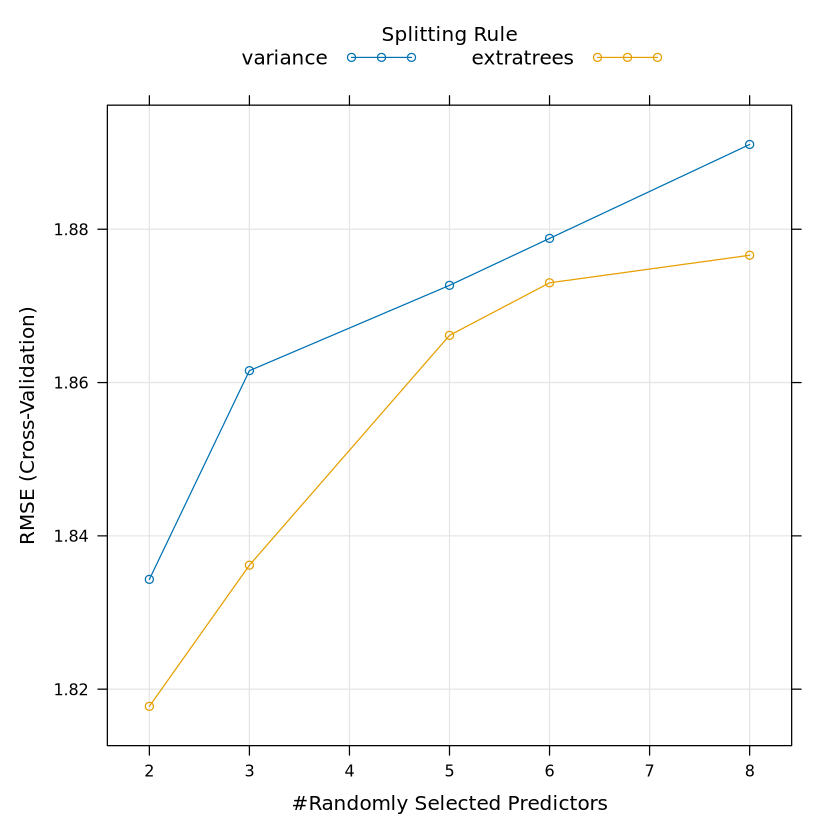

In [23]:
plot(model1)

### Comparing models with CARET

In [102]:
# Create custom indices: myFolds
cdr3_matrix_index <- createDataPartition(cdr3_hla_matrix$cdr3_pc1, p = .75, list = FALSE)
cdr3_matrix_tr <- cdr3_hla_matrix[ cdr3_matrix_index, ]
cdr3_matrix_te <- cdr3_hla_matrix[-cdr3_matrix_index, ]

In [105]:
model1 <- caret::train(cdr3_pc1 ~ allele_R + allele_H + allele_F + allele_Y + allele_G + PC1 + PC2 + PC3,
                      tuneLength = 5,
                      data = cdr3_matrix_tr, 
                      method = 'ranger',
                      trControl = trainControl(
                          method = "cv", 
                          number = 5, 
                          verboseIter = TRUE))
model2 <- caret::train(cdr3_pc1 ~ allele_R + allele_H + allele_F + allele_Y + allele_G + genomic_PC1 + genomic_PC2 + genomic_PC3,
                      tuneLength = 5,
                      data = cdr3_matrix_tr, 
                      method = 'ranger',
                      trControl = trainControl(
                          method = "cv", 
                          number = 5, 
                          verboseIter = TRUE))


+ Fold1: mtry=2, min.node.size=5, splitrule=variance 
- Fold1: mtry=2, min.node.size=5, splitrule=variance 
+ Fold1: mtry=3, min.node.size=5, splitrule=variance 
- Fold1: mtry=3, min.node.size=5, splitrule=variance 
+ Fold1: mtry=5, min.node.size=5, splitrule=variance 
- Fold1: mtry=5, min.node.size=5, splitrule=variance 
+ Fold1: mtry=6, min.node.size=5, splitrule=variance 
- Fold1: mtry=6, min.node.size=5, splitrule=variance 
+ Fold1: mtry=8, min.node.size=5, splitrule=variance 
- Fold1: mtry=8, min.node.size=5, splitrule=variance 
+ Fold1: mtry=2, min.node.size=5, splitrule=extratrees 
- Fold1: mtry=2, min.node.size=5, splitrule=extratrees 
+ Fold1: mtry=3, min.node.size=5, splitrule=extratrees 
- Fold1: mtry=3, min.node.size=5, splitrule=extratrees 
+ Fold1: mtry=5, min.node.size=5, splitrule=extratrees 
- Fold1: mtry=5, min.node.size=5, splitrule=extratrees 
+ Fold1: mtry=6, min.node.size=5, splitrule=extratrees 
- Fold1: mtry=6, min.node.size=5, splitrule=extratrees 
+ Fold1: mtr

In [106]:
model1
model2

Random Forest 

556 samples
  8 predictor

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 446, 444, 445, 445, 444 
Resampling results across tuning parameters:

  mtry  splitrule   RMSE      Rsquared    MAE     
  2     variance    1.870720  0.06981168  1.444276
  2     extratrees  1.845363  0.08634392  1.416535
  3     variance    1.902720  0.05979569  1.472104
  3     extratrees  1.865823  0.07936105  1.438743
  5     variance    1.925961  0.05262008  1.488586
  5     extratrees  1.902334  0.06807239  1.468312
  6     variance    1.926361  0.05343111  1.487017
  6     extratrees  1.909393  0.06744219  1.474046
  8     variance    1.936495  0.05307280  1.490348
  8     extratrees  1.914092  0.06697089  1.485211

Tuning parameter 'min.node.size' was held constant at a value of 5
RMSE was used to select the optimal model using the smallest value.
The final values used for the model were mtry = 2, splitrule = extratrees
 and min.node.size = 5.

Random Forest 

556 samples
  8 predictor

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 444, 444, 447, 445, 444 
Resampling results across tuning parameters:

  mtry  splitrule   RMSE      Rsquared    MAE     
  2     variance    1.895208  0.05213360  1.432991
  2     extratrees  1.870720  0.06945800  1.418462
  3     variance    1.928560  0.03898349  1.455875
  3     extratrees  1.898278  0.05626384  1.441768
  5     variance    1.951292  0.03474079  1.471840
  5     extratrees  1.928701  0.04804962  1.462358
  6     variance    1.962700  0.02925220  1.480588
  6     extratrees  1.938510  0.04527277  1.467402
  8     variance    1.969147  0.02851893  1.479277
  8     extratrees  1.948322  0.04266574  1.475961

Tuning parameter 'min.node.size' was held constant at a value of 5
RMSE was used to select the optimal model using the smallest value.
The final values used for the model were mtry = 2, splitrule = extratrees
 and min.node.size = 5.

In [108]:
predict1 <- predict(model1, cdr3_matrix_te)
predict2 <- predict(model2, cdr3_matrix_te)


Attaching package: ‘AICcPermanova’


The following object is masked from ‘package:fmsb’:

    VIF




### Main Manova with IRT and GROUPS

In [ ]:
data_table_list <- load("/work_beegfs/sukmb667/projects/cdr3-qtl/CDR3QTL/cdr3-hla-pairs/irt_freq_unique.RData")

library(parallel)

process_file <- function(f) {
    pair_matrix <- fread(f)
    mlm_fun(pair_matrix, dir_results, n_pcs = 3)
}

results <- mclapply(pairs_paths, process_file, mc.cores = 4)
final_results <- do.call(rbind, results)
fwrite(final_results, paste0(dir_results, sample_size, '_manova.csv'))



### Mapping IBD patients with UC and CD

In [4]:
cd_uc <- fread('../phenotype_mapping.tsv')

In [5]:
colnames(cd_uc) <- c('patient_id', 'IBD_subtype')

In [6]:
cd_uc$patient_id <- gsub('sample_', 'I', cd_uc$patient_id)

In [8]:
summary_ibd <- cd_uc %>% group_by(IBD_subtype) %>% count()

In [70]:
summary_ibd

IBD_subtype,n
<chr>,<int>
CD,1026
UC,402


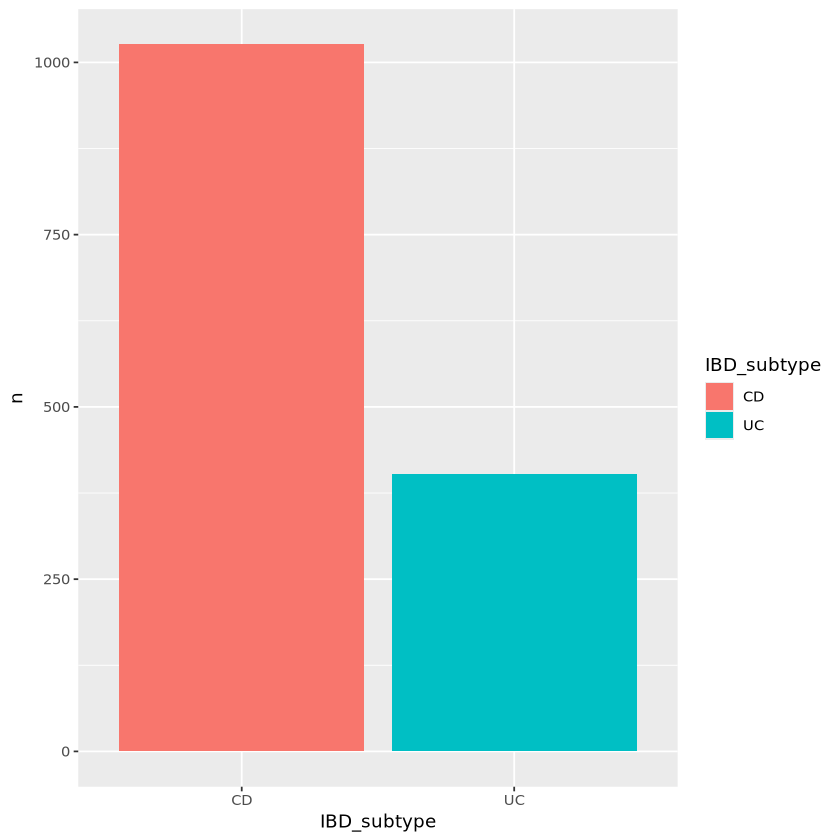

In [10]:
ggplot(summary_ibd, aes(x = IBD_subtype, y = n, fill = IBD_subtype)) +
geom_col()

In [107]:
sites_to_test <- grep('.tsv',
                      list.files('../conditional_analysis//IBD//gene_wise//DQB1/'),
                                value = TRUE, invert = TRUE)

In [111]:
pairs <- '../IBD//cdr3_hla_pairs/'
pairs <- paste0(pairs, list.files(pairs))
indexes <- grepl(paste(paste0(sites_to_test, '_'), collapse = '|'), pairs)
pairs_to_test <- pairs[indexes]
length(pairs_to_test)

[1] 420

In [112]:
pairs_to_test

[1] "../IBD//cdr3_hla_pairs/DQB1_224_12_P106_matrix.tsv"  
  [2] "../IBD//cdr3_hla_pairs/DQB1_224_12_P107_matrix.tsv"  
  [3] "../IBD//cdr3_hla_pairs/DQB1_224_12_P108_matrix.tsv"  
  [4] "../IBD//cdr3_hla_pairs/DQB1_224_12_P109_matrix.tsv"  
  [5] "../IBD//cdr3_hla_pairs/DQB1_224_12_P113_matrix.tsv"  
  [6] "../IBD//cdr3_hla_pairs/DQB1_224_12_P114_matrix.tsv"  
  [7] "../IBD//cdr3_hla_pairs/DQB1_224_12_P115_matrix.tsv"  
  [8] "../IBD//cdr3_hla_pairs/DQB1_224_12_P116_matrix.tsv"  
  [9] "../IBD//cdr3_hla_pairs/DQB1_224_13_P106_matrix.tsv"  
 [10] "../IBD//cdr3_hla_pairs/DQB1_224_13_P107_matrix.tsv"  
 [11] "../IBD//cdr3_hla_pairs/DQB1_224_13_P108_matrix.tsv"  
 [12] "../IBD//cdr3_hla_pairs/DQB1_224_13_P109_matrix.tsv"  
 [13] "../IBD//cdr3_hla_pairs/DQB1_224_13_P110_matrix.tsv"  
 [14] "../IBD//cdr3_hla_pairs/DQB1_224_13_P113_matrix.tsv"  
 [15] "../IBD//cdr3_hla_pairs/DQB1_224_13_P114_matrix.tsv"  
 [16] "../IBD//cdr3_hla_pairs/DQB1_224_13_P115_matrix.tsv"  
 [17] "../IBD//cdr3_hla_pairs/DQB1_224_13_P116_matrix.tsv"  
 [18] "../IBD//cdr3_hla_pairs/DQB1_224_14_P106_matrix.tsv"  
 [19] "../IBD//cdr3_hla_pairs/DQB1_224_14_P107_matrix.tsv"  
 [20] "../IBD//cdr3_hla_pairs/DQB1_224_14_P108_matrix.tsv"  
 [21] "../IBD//cdr3_hla_pairs/DQB1_224_14_P109_matrix.tsv"  
 [22] "../IBD//cdr3_hla_pairs/DQB1_224_14_P110_matrix.tsv"  
 [23] "../IBD//cdr3_hla_pairs/DQB1_224_14_P112_matrix.tsv"  
 [24] "../IBD//cdr3_hla_pairs/DQB1_224_14_P113_matrix.tsv"  
 [25] "../IBD//cdr3_hla_pairs/DQB1_224_14_P114_matrix.tsv"  
 [26] "../IBD//cdr3_hla_pairs/DQB1_224_14_P115_matrix.tsv"  
 [27] "../IBD//cdr3_hla_pairs/DQB1_224_14_P116_matrix.tsv"  
 [28] "../IBD//cdr3_hla_pairs/DQB1_224_15_P106_matrix.tsv"  
 [29] "../IBD//cdr3_hla_pairs/DQB1_224_15_P107_matrix.tsv"  
 [30] "../IBD//cdr3_hla_pairs/DQB1_224_15_P108_matrix.tsv"  
 [31] "../IBD//cdr3_hla_pairs/DQB1_224_15_P109_matrix.tsv"  
 [32] "../IBD//cdr3_hla_pairs/DQB1_224_15_P110_matrix.tsv"  
 [33] "../IBD//cdr3_hla_pairs/DQB1_224_15_P111_matrix.tsv"  
 [34] "../IBD//cdr3_hla_pairs/DQB1_224_15_P112_matrix.tsv"  
 [35] "../IBD//cdr3_hla_pairs/DQB1_224_15_P113_matrix.tsv"  
 [36] "../IBD//cdr3_hla_pairs/DQB1_224_15_P114_matrix.tsv"  
 [37] "../IBD//cdr3_hla_pairs/DQB1_224_15_P115_matrix.tsv"  
 [38] "../IBD//cdr3_hla_pairs/DQB1_224_16_P106_matrix.tsv"  
 [39] "../IBD//cdr3_hla_pairs/DQB1_224_16_P107_matrix.tsv"  
 [40] "../IBD//cdr3_hla_pairs/DQB1_224_16_P108_matrix.tsv"  
 [41] "../IBD//cdr3_hla_pairs/DQB1_224_16_P109_matrix.tsv"  
 [42] "../IBD//cdr3_hla_pairs/DQB1_224_16_P110_matrix.tsv"  
 [43] "../IBD//cdr3_hla_pairs/DQB1_224_16_P111_matrix.tsv"  
 [44] "../IBD//cdr3_hla_pairs/DQB1_224_16_P112_matrix.tsv"  
 [45] "../IBD//cdr3_hla_pairs/DQB1_224_16_P112.1_matrix.tsv"
 [46] "../IBD//cdr3_hla_pairs/DQB1_224_16_P113_matrix.tsv"  
 [47] "../IBD//cdr3_hla_pairs/DQB1_224_16_P114_matrix.tsv"  
 [48] "../IBD//cdr3_hla_pairs/DQB1_224_16_P115_matrix.tsv"  
 [49] "../IBD//cdr3_hla_pairs/DQB1_224_17_P106_matrix.tsv"  
 [50] "../IBD//cdr3_hla_pairs/DQB1_224_17_P107_matrix.tsv"  
 [51] "../IBD//cdr3_hla_pairs/DQB1_224_17_P108_matrix.tsv"  
 [52] "../IBD//cdr3_hla_pairs/DQB1_224_17_P109_matrix.tsv"  
 [53] "../IBD//cdr3_hla_pairs/DQB1_224_17_P110_matrix.tsv"  
 [54] "../IBD//cdr3_hla_pairs/DQB1_224_17_P111_matrix.tsv"  
 [55] "../IBD//cdr3_hla_pairs/DQB1_224_17_P111.1_matrix.tsv"
 [56] "../IBD//cdr3_hla_pairs/DQB1_224_17_P112_matrix.tsv"  
 [57] "../IBD//cdr3_hla_pairs/DQB1_224_17_P112.1_matrix.tsv"
 [58] "../IBD//cdr3_hla_pairs/DQB1_224_17_P113_matrix.tsv"  
 [59] "../IBD//cdr3_hla_pairs/DQB1_224_17_P114_matrix.tsv"  
 [60] "../IBD//cdr3_hla_pairs/DQB1_224_18_P107_matrix.tsv"  
 [61] "../IBD//cdr3_hla_pairs/DQB1_224_18_P108_matrix.tsv"  
 [62] "../IBD//cdr3_hla_pairs/DQB1_224_18_P109_matrix.tsv"  
 [63] "../IBD//cdr3_hla_pairs/DQB1_224_18_P110_matrix.tsv"  
 [64] "../IBD//cdr3_hla_pairs/DQB1_224_18_P111_matrix.tsv"  
 [65] "../IBD//cdr3_hla_pairs/DQB1_224_18_P111.1_matrix.tsv"
 [66] "../IBD//cdr3_hla_pairs/DQB1_22

In [113]:
dir_results <- '../IBD/manova_uc/'
first <- TRUE
for (f in pairs_to_test){
    cdr3_hla_pair <- fread(f)
    cdr3_hla_matrix <- merge(cdr3_hla_pair, cd_uc, by = 'patient_id') %>% filter(IBD_subtype == 'UC')
    manova_df <- mlm_fun(cdr3_hla_matrix, dir_results, n_pcs = 3)
    if (first){
        manova_df_all <- manova_df[0,]
        first <- FALSE
    }
    if (is.null(manova_df)){
        next
    } else {
        manova_df_all <- rbind(manova_df_all, manova_df) 
        }
    }
    
fwrite(manova_df_all, paste0(dir_results, 'manova_UC_DQB1.tsv'), sep = '\t')

Warning message in mvlm(formula_full, cdr3_hla_matrix):
“Adjusted sample size = 38
Asymptotic properties of the null distribution may not hold.
This can result in overly conservative p-values.
Increased sample size is recommended.”
Warning message in mvlm(formula_null, cdr3_hla_matrix):
“Adjusted sample size = 38
Asymptotic properties of the null distribution may not hold.
This can result in overly conservative p-values.
Increased sample size is recommended.”
Error: Error in if (na.omit(manova_df)$`Pr(>F)` < bonf) {: argument is of length zero


Warning message in mvlm(formula_full, cdr3_hla_matrix):
“Adjusted sample size = 34
Asymptotic properties of the null distribution may not hold.
This can result in overly conservative p-values.
Increased sample size is recommended.”
Warning message in mvlm(formula_null, cdr3_hla_matrix):
“Adjusted sample size = 34
Asymptotic properties of the null distribution may not hold.
This can result in overly conservative p-values.
Increased sample size i

Warning message:
“Removed 1260 rows containing missing values or values outside the scale range (`geom_point()`).”


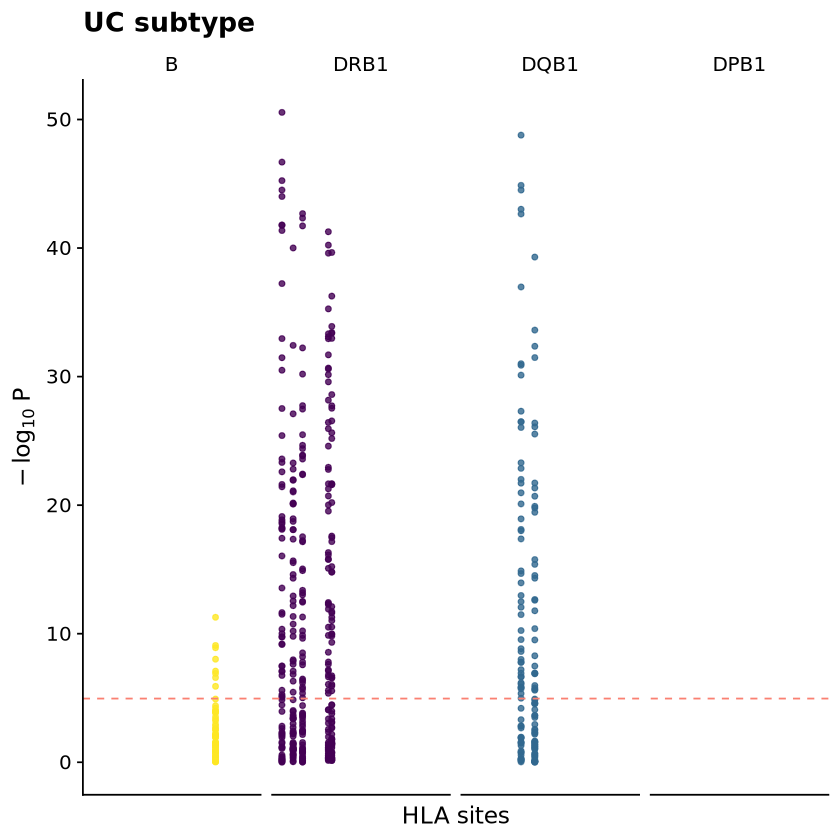

In [63]:
bonf <- 0.01 / 900
hla_genes <- c('A', 'C', 'B','DRB1','DQA1','DQB1','DPA1', 'DPB1')
manova_uc <- manova_df_all %>% 
    separate(pair, into = c('HLA', 'Site_hla', 'Length_cdr3', 'Position_cdr3'), sep = ':', remove = FALSE) %>%
    mutate(Site_hla = as.integer(Site_hla))
pl_manova_uc <- ggplot() +
    geom_point(data = manova_uc, aes(x = Site_hla, y = -log10(`Pr(>F)`), color=as.factor(HLA)), alpha=0.8, size=1.3, show.legend = FALSE) +
    scale_color_viridis_d('magma', direction = -1) +
    #scale_x_discrete(breaks = as.integer(seq(0,300, length.out = 5))) +
    labs(x = "HLA sites", y = expression(paste(-log[10], " ", P))) +
    geom_hline(yintercept= - log10(bonf), linetype="dashed", color = "salmon") +
    theme(legend.position = "none") +
    theme_cowplot() +
    facet_grid(~factor(HLA, levels = hla_genes), space = "free") +
    theme(axis.text.x = element_blank(), strip.background = element_rect(fill = "white"),  
          axis.ticks.x=element_blank()) +
    ggtitle('UC subtype') #+
    #ylim(0,250)
    #geom_segment(data = hla_annotation, aes(x = start, xend = end, y=-0.01, yend=-0.01), color = 'blue', label = NA)
pl_manova_uc
#ggsave('../plots/manhattan_plot_wo_correlation_9PCs.jpg',pl_ours_9PCs, width = 10, height = 4)

In [115]:
dir_results <- '../IBD/manova_cd/'
first <- TRUE
for (f in pairs_to_test){
    cdr3_hla_pair <- fread(f)
    cdr3_hla_matrix <- merge(cdr3_hla_pair, cd_uc, by = 'patient_id') %>% filter(IBD_subtype == 'CD')
    cdr3_hla_matrix <- cdr3_hla_matrix[sample(nrow(cdr3_hla_matrix), 400)]
    manova_df <- mlm_fun(cdr3_hla_matrix, dir_results, n_pcs = 3)
    if (first){
        manova_df_all <- manova_df[0,]
        first <- FALSE
    }
    if (is.null(manova_df)){
        next
    } else {
        manova_df_all <- rbind(manova_df_all, manova_df) 
        }
    }
fwrite(manova_df_all, paste0(dir_results, 'manova_dCD_DQB1.tsv'), sep = '\t')

Warning message in mvlm(formula_full, cdr3_hla_matrix):
“Adjusted sample size = 56
Asymptotic properties of the null distribution may not hold.
This can result in overly conservative p-values.
Increased sample size is recommended.”
Warning message in mvlm(formula_null, cdr3_hla_matrix):
“Adjusted sample size = 56
Asymptotic properties of the null distribution may not hold.
This can result in overly conservative p-values.
Increased sample size is recommended.”
Error: Error in if (na.omit(manova_df)$`Pr(>F)` < bonf) {: argument is of length zero


Warning message in mvlm(formula_full, cdr3_hla_matrix):
“Adjusted sample size = 39
Asymptotic properties of the null distribution may not hold.
This can result in overly conservative p-values.
Increased sample size is recommended.”
Warning message in mvlm(formula_null, cdr3_hla_matrix):
“Adjusted sample size = 39
Asymptotic properties of the null distribution may not hold.
This can result in overly conservative p-values.
Increased sample size i

Warning message:
“Removed 1260 rows containing missing values or values outside the scale range (`geom_point()`).”


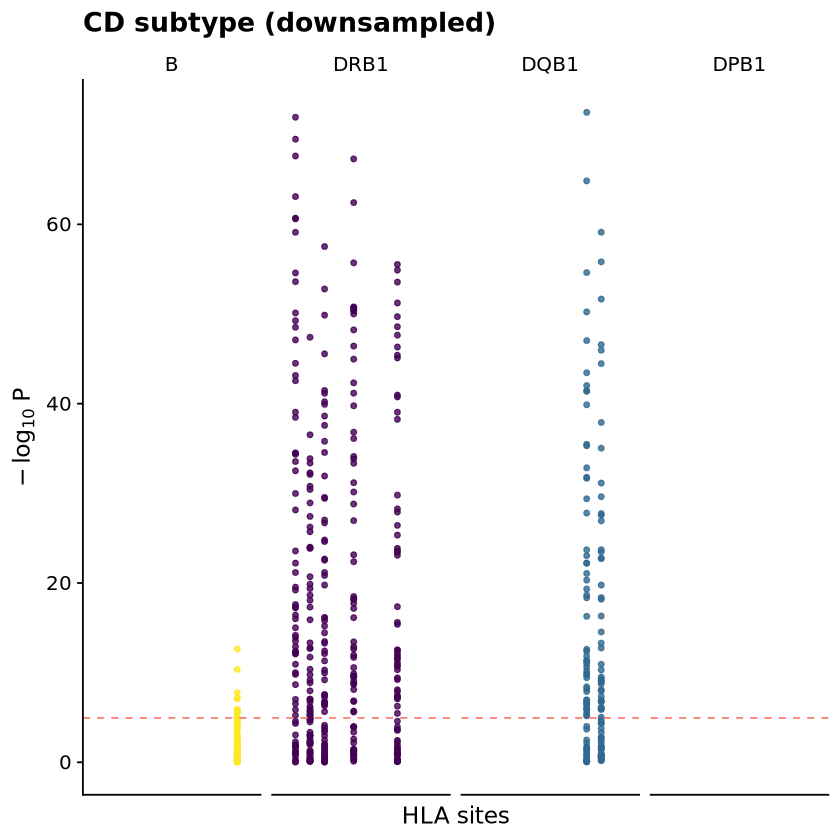

In [79]:
bonf <- 0.01 / 900
hla_genes <- c('A', 'C', 'B','DRB1','DQA1','DQB1','DPA1', 'DPB1')
manova_cd <- manova_df_all %>% 
    separate(pair, into = c('HLA', 'Site_hla', 'Length_cdr3', 'Position_cdr3'), sep = ':', remove = FALSE) %>%
    mutate(Site_hla = as.integer(Site_hla))
pl_manova_cd <- ggplot() +
    geom_point(data = manova_cd, aes(x = as.factor(Site_hla), y = -log10(`Pr(>F)`), color=as.factor(HLA)), alpha=0.8, size=1.3, show.legend = FALSE) +
    scale_color_viridis_d('magma', direction = -1) +
    #scale_x_discrete(breaks = as.integer(seq(0,300, length.out = 5))) +
    labs(x = "HLA sites", y = expression(paste(-log[10], " ", P))) +
    geom_hline(yintercept= - log10(bonf), linetype="dashed", color = "salmon") +
    theme(legend.position = "none") +
    theme_cowplot() +
    facet_grid(~factor(HLA, levels = hla_genes), space = "free") +
    theme(axis.text.x = element_blank(), strip.background = element_rect(fill = "white"),  
          axis.ticks.x=element_blank()) +
    ggtitle('CD subtype (downsampled)') #+
    #ylim(0,250)
    #geom_segment(data = hla_annotation, aes(x = start, xend = end, y=-0.01, yend=-0.01), color = 'blue', label = NA)
pl_manova_cd
#ggsave('../plots/manhattan_plot_wo_correlation_9PCs.jpg',pl_ours_9PCs, width = 10, height = 4)

In [117]:
cd <- fread('../IBD/manova_cd/manova_dCD_DQB1.tsv') %>% mutate(IBD_subtype = 'CD')
uc <- fread('../IBD/manova_uc/manova_UC_DQB1.tsv') %>% mutate(IBD_subtype = 'UC')
manova_both <- rbind(cd, uc) 

In [121]:
manova_both <- manova_both %>% 
    separate(pair, into = c('HLA', 'Site_hla', 'Length_cdr3', 'Position_cdr3'), sep = ':', remove = FALSE)

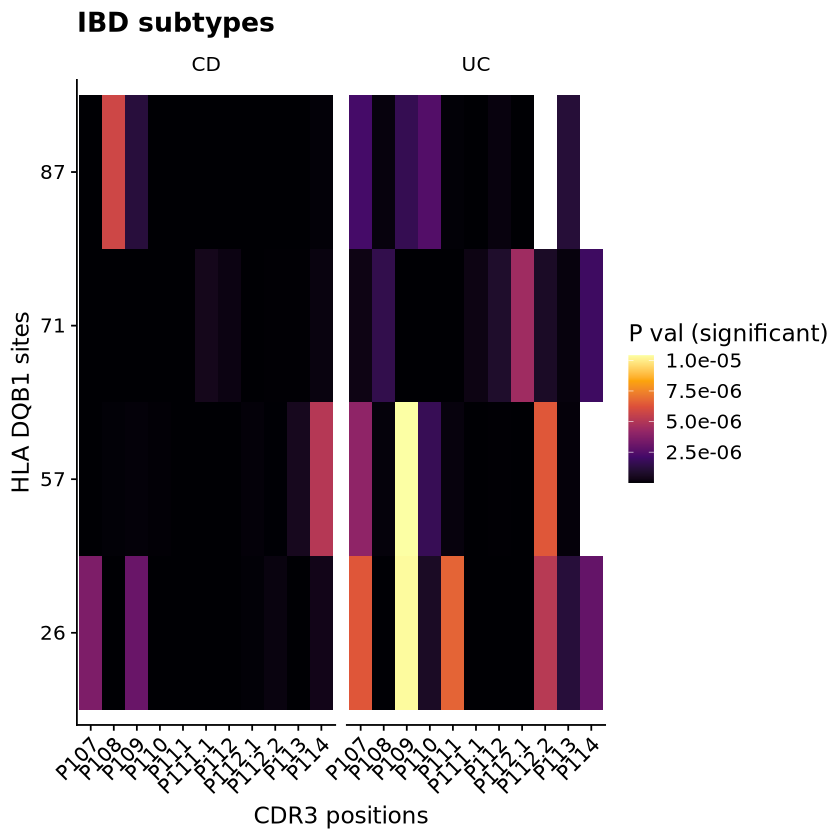

In [129]:
cd_uc_plot <- ggplot(data = manova_both %>% filter(`Pr(>F)` < 0.01/900), aes(x = Position_cdr3, y = as.factor(Site_hla), fill = `Pr(>F)`)) + 
    geom_tile() +
    scale_fill_viridis_c( option = 'inferno') + 
    theme_cowplot() +
    labs( x = 'CDR3 positions', y = 'HLA DQB1 sites', fill = 'P val (significant)', title = 'IBD subtypes') +
    facet_grid(~ IBD_subtype , scales = 'free') + 
    theme(axis.text.x = element_text(angle = 45, hjust = 1), strip.background = element_rect(fill = "white"))
cd_uc_plot

In [127]:
0.01/900

[1] 1.111111e-05

In [130]:
ggsave('../plots/cd_vc_uc_2.png', cd_uc_plot, width = 10, height = 15)

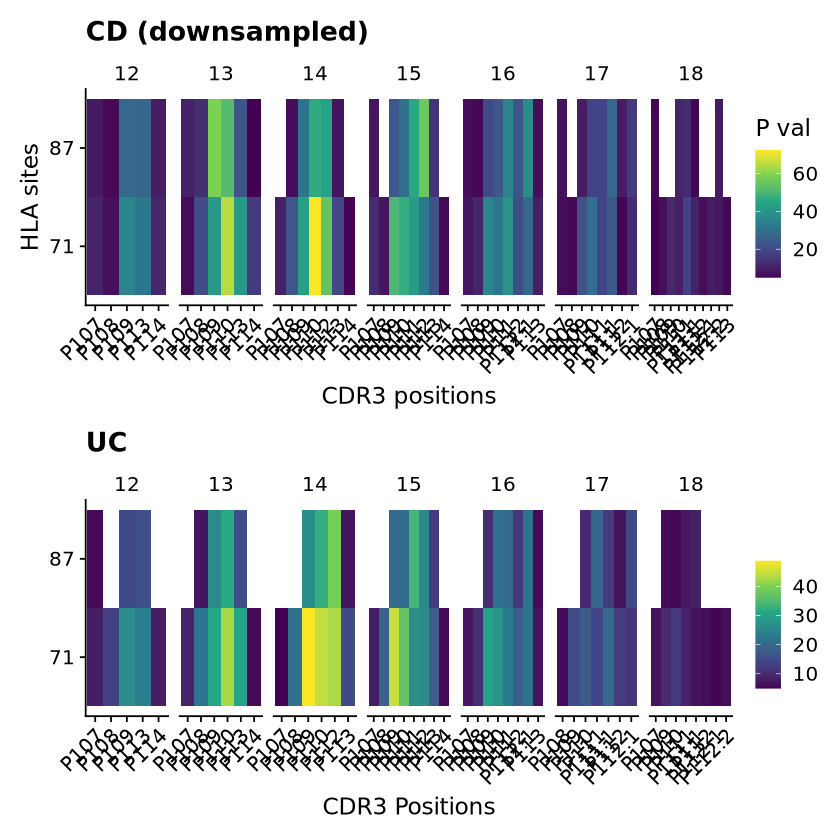

In [105]:
both

In [40]:
main_manova_healthy <- na.omit(fread('../HEALTHY/manova_results.tsv')) %>% 
    separate(pair, into = c('HLA', 'Site_hla', 'Length_cdr3', 'Position_cdr3'), sep = ':', remove = FALSE) %>% 
    arrange(., Pr..F., desc(variance_explained))
main_manova_healthy #%>% filter(str_detect(pair, 'DQA1:25'))

In [3]:
main_manova_ibd <- na.omit(fread('../IBD/manova_results.tsv')) %>% 
    separate(pair, into = c('HLA', 'Site_hla', 'Length_cdr3', 'Position_cdr3'), sep = ':', remove = FALSE) %>% 
    arrange(., Pr..F., desc(variance_explained))
downsampled_manova_ibd <- na.omit(fread('../IBD/manova_results_downsampled.tsv')) %>% 
    separate(pair, into = c('HLA', 'Site_hla', 'Length_cdr3', 'Position_cdr3'), sep = ':', remove = FALSE) %>% 
    arrange(., Pr..F., desc(variance_explained))
head(main_manova_ibd) #%>% filter(str_detect(pair, 'DQA1:25'))
head(downsampled_manova_ibd)

In [ ]:
main_manova <- na.omit(fread('../HEALTHY/manova_results.tsv')) %>% 
    separate(pair, into = c('HLA', 'Site_hla', 'Length_cdr3', 'Position_cdr3'), sep = ':', remove = FALSE) %>% 
    arrange(., Pr..F., desc(variance_explained))
bonf <- 0.01 / nrow(main_manova)
hla_genes <- c('DRB1','A', 'B', 'C', 'DPA1', 'DPB1', 'DQA1','DQB1')

cond_manova_template <- read_tsv('../conditional_analysis//v2//manova_template.tsv')[0,] %>% 
    separate(pair, into = c('HLA', 'Site_hla', 'Length_cdr3', 'Position_cdr3'), sep = ':', remove = FALSE)

for (gene in hla_genes){
    
    manova_df_all <- cond_manova_template
    
    gene_manova <- main_manova %>% filter(HLA == gene) 
    hit <- gene_manova$pair[1]
    g_s_l_p <- unlist(strsplit(hit, ':'))
    condition_site <- paste(g_s_l_p[1:2], collapse= '_')
    condition_site_df <- fread(paste0('../hla_matrices/all_variable_sites/', grep(paste0(condition_site, '_'), list.files('../hla_matrices/all_variable_sites/'), value = TRUE))) %>%
        dplyr::select(-G_S)
    colnames(condition_site_df) <- gsub('allele', condition_site, colnames(condition_site_df))
    sites <- colnames(condition_site_df)[-1]
    hit_pattern <- paste0(gsub('_', ':', condition_site),':')
    pairs_to_test <- grep(hit_pattern, paste0('../HEALTHY/cdr3_hla_pairs/',grep(paste0(gene,':'), list.files('../HEALTHY/cdr3_hla_pairs/'), value = TRUE)), value = TRUE, invert = TRUE)
    dir_matrices <- paste0('../conditional_analysis//HEALTHY/',gene,'/', condition_site,'/cdr3_hla_pairs/')
    dir_results <- paste0('../conditional_analysis//HEALTHY/',gene,'/', condition_site,'/')
        
    if (!file.exists(dir_matrices)) {
    dir.create(dir_matrices, recursive = TRUE)
    }
    if (!file.exists(dir_results)) {
    dir.create(dir_results, recursive = TRUE)
    }
    manova_df_site <- cond_manova_template
    
    for (f in pairs_to_test){
        cdr3_hla_condition_matrix <- fread(f) %>% left_join(condition_site_df, by = 'patient_id')
        cdr3_hla_pair_name <- cdr3_hla_condition_matrix$pair[1]
        fwrite(cdr3_hla_condition_matrix, paste0(dir_matrices,cdr3_hla_pair_name,':',condition_site,'.tsv'), sep = '\t')
        manova_df <- mlm_fun_conditional(cdr3_hla_condition_matrix, dir_results, sites) %>% 
            separate(pair, into = c('HLA', 'Site_hla', 'Length_cdr3', 'Position_cdr3'), sep = ':', remove = FALSE) %>% 
            mutate(condition = condition_site)
        manova_df_site <- rbind(manova_df_site, manova_df)
        
    }
    fwrite(manova_df_site, paste0(dir_results, 'manova_',condition_site,'.tsv'))
    manova_df_all <- rbind(manova_df_all, manova_df_site)

    while (nrow(manova_df_site %>% filter(Pr..F.<bonf)) > 0){
        manova_results <- na.omit(fread(paste0('../conditional_analysis/HEALTHY/',gene,'/',condition_site,'/manova_',condition_site,'.tsv'))) %>% 
            arrange(., Pr..F.,desc(variance_explained))
         
        hit <- manova_results$pair[1]
        g_s_l_p <- unlist(strsplit(hit, ':'))

        condition_site <- paste(g_s_l_p[1:2], collapse= '_')
        hit_pattern <- paste0(gsub('_', ':', condition_site),':')
        condition_site_df <- fread(paste0('../hla_matrices/all_variable_sites/', grep(paste0(condition_site, '_'), list.files('../hla_matrices/all_variable_sites/'), value = TRUE))) %>% 
            dplyr::select(-G_S)
        colnames(condition_site_df) <- gsub('allele', condition_site, colnames(condition_site_df))
        site <- colnames(condition_site_df)[-1]
        sites <- c(sites, site)
        pairs_survived <- unique(lapply(unique(manova_results %>% filter(Pr..F. < bonf) %>% pull(pair)), function(x) paste0(paste(unlist(strsplit(x, ':'))[1:2], collapse = ':'), ':') ))
        pairs_to_test <- grep(hit_pattern, paste0(dir_matrices, grep(paste(pairs_survived, collapse = '|'), list.files(dir_matrices), value = TRUE)), value = TRUE, invert = TRUE)
    
        dir_matrices <- paste0('../conditional_analysis//HEALTHY/',gene,'/', condition_site,'/cdr3_hla_pairs/')
        dir_results <- paste0('../conditional_analysis//HEALTHY/',gene,'/', condition_site,'/')
            
        if (!file.exists(dir_matrices)) {
        dir.create(dir_matrices, recursive = TRUE)
        }
        if (!file.exists(dir_results)) {
        dir.create(dir_results, recursive = TRUE)
        }
        manova_df_site <- cond_manova_template
        
        for (f in pairs_to_test){
            cdr3_hla_condition_matrix <- fread(f) %>% left_join(condition_site_df, by = 'patient_id')
            cdr3_hla_pair_name <- cdr3_hla_condition_matrix$pair[1]
            fwrite(cdr3_hla_condition_matrix, paste0(dir_matrices,cdr3_hla_pair_name,':',condition_site,'.tsv'), sep = '\t')
            manova_df <- mlm_fun_conditional(cdr3_hla_condition_matrix, dir_results, sites) %>% 
                separate(pair, into = c('HLA', 'Site_hla', 'Length_cdr3', 'Position_cdr3'), sep = ':', remove = FALSE) %>% 
                mutate(condition = condition_site)
            manova_df_site <- rbind(manova_df_site, manova_df)
            
        }
        fwrite(manova_df_site, paste0(dir_results, 'manova_',condition_site,'.tsv'), sep = '\t')
        manova_df_all <- rbind(manova_df_all, manova_df_site)
            
    }
    fwrite(manova_df_all, paste0('../conditional_analysis//HEALTHY/manova_',gene,'.tsv'), sep = '\t')
    }


main_manova <- na.omit(fread('../IBD/manova_results.tsv')) %>% 
    separate(pair, into = c('HLA', 'Site_hla', 'Length_cdr3', 'Position_cdr3'), sep = ':', remove = FALSE) %>% 
    arrange(., Pr..F., desc(variance_explained))
bonf <- 0.01 / nrow(main_manova)

cond_manova_template <- read_tsv('../conditional_analysis//v2//manova_template.tsv')[0,] %>% 
    separate(pair, into = c('HLA', 'Site_hla', 'Length_cdr3', 'Position_cdr3'), sep = ':', remove = FALSE)

for (gene in hla_genes){
    
    manova_df_all <- cond_manova_template
    
    gene_manova <- main_manova %>% filter(HLA == gene) 
    hit <- gene_manova$pair[1]
    g_s_l_p <- unlist(strsplit(hit, ':'))
    condition_site <- paste(g_s_l_p[1:2], collapse= '_')
    condition_site_df <- fread(paste0('../hla_matrices/all_variable_sites/', grep(paste0(condition_site, '_'), list.files('../hla_matrices/all_variable_sites/'), value = TRUE))) %>%
        dplyr::select(-G_S)
    colnames(condition_site_df) <- gsub('allele', condition_site, colnames(condition_site_df))
    sites <- colnames(condition_site_df)[-1]
    hit_pattern <- paste0(gsub('_', ':', condition_site),':')
    pairs_to_test <- grep(hit_pattern, paste0('../IBD/cdr3_hla_pairs/',grep(paste0(gene,':'), list.files('../IBD/cdr3_hla_pairs/'), value = TRUE)), value = TRUE, invert = TRUE)
    dir_matrices <- paste0('../conditional_analysis//IBD/',gene,'/', condition_site,'/cdr3_hla_pairs/')
    dir_results <- paste0('../conditional_analysis//IBD/',gene,'/', condition_site,'/')
        
    if (!file.exists(dir_matrices)) {
    dir.create(dir_matrices, recursive = TRUE)
    }
    if (!file.exists(dir_results)) {
    dir.create(dir_results, recursive = TRUE)
    }
    manova_df_site <- cond_manova_template
    
    for (f in pairs_to_test){
        cdr3_hla_condition_matrix <- fread(f) %>% left_join(condition_site_df, by = 'patient_id')
        cdr3_hla_pair_name <- cdr3_hla_condition_matrix$pair[1]
        fwrite(cdr3_hla_condition_matrix, paste0(dir_matrices,cdr3_hla_pair_name,':',condition_site,'.tsv'), sep = '\t')
        manova_df <- mlm_fun_conditional(cdr3_hla_condition_matrix, dir_results, sites) %>% 
            separate(pair, into = c('HLA', 'Site_hla', 'Length_cdr3', 'Position_cdr3'), sep = ':', remove = FALSE) %>% 
            mutate(condition = condition_site)
        manova_df_site <- rbind(manova_df_site, manova_df)
        
    }
    fwrite(manova_df_site, paste0(dir_results, 'manova_',condition_site,'.tsv'))
    manova_df_all <- rbind(manova_df_all, manova_df_site)

    while (nrow(manova_df_site %>% filter(Pr..F.<bonf)) > 0){
        manova_results <- na.omit(fread(paste0('../conditional_analysis/IBD/',gene,'/',condition_site,'/manova_',condition_site,'.tsv'))) %>% 
            arrange(., Pr..F.,desc(variance_explained))
         
        hit <- manova_results$pair[1]
        g_s_l_p <- unlist(strsplit(hit, ':'))

        condition_site <- paste(g_s_l_p[1:2], collapse= '_')
        hit_pattern <- paste0(gsub('_', ':', condition_site),':')
        condition_site_df <- fread(paste0('../hla_matrices/all_variable_sites/', grep(paste0(condition_site, '_'), list.files('../hla_matrices/all_variable_sites/'), value = TRUE))) %>% 
            dplyr::select(-G_S)
        colnames(condition_site_df) <- gsub('allele', condition_site, colnames(condition_site_df))
        site <- colnames(condition_site_df)[-1]
        sites <- c(sites, site)
        pairs_survived <- unique(lapply(unique(manova_results %>% filter(Pr..F. < bonf) %>% pull(pair)), function(x) paste0(paste(unlist(strsplit(x, ':'))[1:2], collapse = ':'), ':') ))
        pairs_to_test <- grep(hit_pattern, paste0(dir_matrices, grep(paste(pairs_survived, collapse = '|'), list.files(dir_matrices), value = TRUE)), value = TRUE, invert = TRUE)
    
        dir_matrices <- paste0('../conditional_analysis//IBD/',gene,'/', condition_site,'/cdr3_hla_pairs/')
        dir_results <- paste0('../conditional_analysis//IBD/',gene,'/', condition_site,'/')
            
        if (!file.exists(dir_matrices)) {
        dir.create(dir_matrices, recursive = TRUE)
        }
        if (!file.exists(dir_results)) {
        dir.create(dir_results, recursive = TRUE)
        }
        manova_df_site <- cond_manova_template
        
        for (f in pairs_to_test){
            cdr3_hla_condition_matrix <- fread(f) %>% left_join(condition_site_df, by = 'patient_id')
            cdr3_hla_pair_name <- cdr3_hla_condition_matrix$pair[1]
            fwrite(cdr3_hla_condition_matrix, paste0(dir_matrices,cdr3_hla_pair_name,':',condition_site,'.tsv'), sep = '\t')
            manova_df <- mlm_fun_conditional(cdr3_hla_condition_matrix, dir_results, sites) %>% 
                separate(pair, into = c('HLA', 'Site_hla', 'Length_cdr3', 'Position_cdr3'), sep = ':', remove = FALSE) %>% 
                mutate(condition = condition_site)
            manova_df_site <- rbind(manova_df_site, manova_df)
            
        }
        fwrite(manova_df_site, paste0(dir_results, 'manova_',condition_site,'.tsv'), sep = '\t')
        manova_df_all <- rbind(manova_df_all, manova_df_site)
            
    }
    fwrite(manova_df_all, paste0('../conditional_analysis//IBD/manova_',gene,'.tsv'), sep = '\t')
    }


In [19]:
-log10(.Machine$double.xmin)

[1] 307.6527

### Across all sites in HEALTHY

In [ ]:
main_manova <- na.omit(fread('../HEALTHY/manova_results.tsv')) %>% 
    separate(pair, into = c('HLA', 'Site_hla', 'Length_cdr3', 'Position_cdr3'), sep = ':', remove = FALSE) %>% 
    arrange(., Pr..F., desc(variance_explained))
bonf <- 0.01 / nrow(main_manova)

cond_manova_template <- read_tsv('../conditional_analysis//v2//manova_template.tsv')[0,] %>% 
    separate(pair, into = c('HLA', 'Site_hla', 'Length_cdr3', 'Position_cdr3'), sep = ':', remove = FALSE)

  
manova_df_all <- cond_manova_template

hit <- main_manova$pair[1]
g_s_l_p <- unlist(strsplit(hit, ':'))
condition_site <- paste(g_s_l_p[1:2], collapse= '_')
condition_site_df <- fread(paste0('../hla_matrices_v3/wo_correlation//', grep(paste0(condition_site, '_'), list.files('../hla_matrices_v3/wo_correlation//'), value = TRUE))) %>%
    dplyr::select(-G_S)
colnames(condition_site_df) <- gsub('allele', condition_site, colnames(condition_site_df))
sites <- colnames(condition_site_df)[-1]
hit_pattern <- paste0(gsub('_', ':', condition_site),':')
pairs_to_test <- grep(hit_pattern,paste0('../HEALTHY/cdr3_hla_pairs/', list.files('../HEALTHY/cdr3_hla_pairs/')), value = TRUE, invert = TRUE)
dir_matrices <- paste0('../conditional_analysis/HEALTHY/all/',condition_site,'/cdr3_hla_pairs/')
dir_results <- paste0('../conditional_analysis/HEALTHY/all/', condition_site,'/')
    
if (!file.exists(dir_matrices)) {
dir.create(dir_matrices, recursive = TRUE)
}
if (!file.exists(dir_results)) {
dir.create(dir_results, recursive = TRUE)
}

manova_df_site <- cond_manova_template

for (f in pairs_to_test){
    cdr3_hla_condition_matrix <- fread(f) %>% left_join(condition_site_df, by = 'patient_id')
    cdr3_hla_pair_name <- cdr3_hla_condition_matrix$pair[1]
    fwrite(cdr3_hla_condition_matrix, paste0(dir_matrices,cdr3_hla_pair_name,':',condition_site,'.tsv'), sep = '\t')
    manova_df <- mlm_fun_conditional(cdr3_hla_condition_matrix, dir_results, sites) %>% 
        separate(pair, into = c('HLA', 'Site_hla', 'Length_cdr3', 'Position_cdr3'), sep = ':', remove = FALSE) %>% 
        mutate(condition = condition_site)
    manova_df_site <- rbind(manova_df_site, manova_df)
    
}
fwrite(manova_df_site, paste0(dir_results, 'manova_',condition_site,'.tsv'))
manova_df_all <- rbind(manova_df_all, manova_df_site)

while (nrow(manova_df_site %>% filter(Pr..F.<bonf)) > 0){
    manova_results <- na.omit(fread(paste0('../conditional_analysis/HEALTHY/all/',condition_site,'/manova_',condition_site,'.tsv'))) %>% 
        arrange(., Pr..F.,desc(variance_explained))
     
    hit <- manova_results$pair[1]
    g_s_l_p <- unlist(strsplit(hit, ':'))

    condition_site <- paste(g_s_l_p[1:2], collapse= '_')
    hit_pattern <- paste0(gsub('_', ':', condition_site),':')
    condition_site_df <- fread(paste0('../hla_matrices_v3//wo_correlation/', grep(paste0(condition_site, '_'), list.files('../hla_matrices_v3//wo_correlation/'), value = TRUE))) %>% 
        dplyr::select(-G_S)
    colnames(condition_site_df) <- gsub('allele', condition_site, colnames(condition_site_df))
    site <- colnames(condition_site_df)[-1]
    sites <- c(sites, site)
    pairs_survived <- unique(lapply(unique(manova_results %>% filter(Pr..F. < bonf) %>% pull(pair)), function(x) paste0(paste(unlist(strsplit(x, ':'))[1:2], collapse = ':'), ':') ))
    pairs_to_test <- grep(hit_pattern, paste0(dir_matrices, grep(paste(pairs_survived, collapse = '|'), list.files(dir_matrices), value = TRUE)), value = TRUE, invert = TRUE)

    dir_matrices <- paste0('../conditional_analysis/HEALTHY/all/', condition_site,'/cdr3_hla_pairs/')
    dir_results <- paste0('../conditional_analysis/HEALTHY/all/', condition_site,'/')
        
    if (!file.exists(dir_matrices)) {
    dir.create(dir_matrices, recursive = TRUE)
    }
    if (!file.exists(dir_results)) {
    dir.create(dir_results, recursive = TRUE)
    }
    manova_df_site <- cond_manova_template
    
    for (f in pairs_to_test){
        cdr3_hla_condition_matrix <- fread(f) %>% left_join(condition_site_df, by = 'patient_id')
        cdr3_hla_pair_name <- cdr3_hla_condition_matrix$pair[1]
        fwrite(cdr3_hla_condition_matrix, paste0(dir_matrices,cdr3_hla_pair_name,':',condition_site,'.tsv'), sep = '\t')
        manova_df <- mlm_fun_conditional(cdr3_hla_condition_matrix, dir_results, sites) %>% 
            separate(pair, into = c('HLA', 'Site_hla', 'Length_cdr3', 'Position_cdr3'), sep = ':', remove = FALSE) %>% 
            mutate(condition = condition_site)
        manova_df_site <- rbind(manova_df_site, manova_df)
        
    }
    fwrite(manova_df_site, paste0(dir_results, 'manova_',condition_site,'.tsv'), sep = '\t')
    manova_df_all <- rbind(manova_df_all, manova_df_site)
        
}

fwrite(manova_df_all, paste0('../conditional_analysis/HEALTHY/all/manova_all.tsv'), sep = '\t')


Rows: 3692 Columns: 14
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (3): pair, model, condition
dbl (11): Res.Df, Df, Gen.var., Pillai, approx.F, num.Df, den.Df, Pr..F., Om...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message in data.frame(Omnibus, model = c("null", "full"), P_val, variance_explained):
“row names were found from a short variable and have been discarded”
Warning message:
“Expected 4 pieces. Missing pieces filled with `NA` in 2 rows [1, 2].”
Warning message in data.frame(Omnibus, model = c("null", "full"), P_val, variance_explained):
“row names were found from a short variable and have been discarded”
Warning 

### Across all sites in downsampled IBD

In [ ]:
source('R_scripts/Conditional_dIBD_prev_approach.R')

Rows: 3692 Columns: 14
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (3): pair, model, condition
dbl (11): Res.Df, Df, Gen.var., Pillai, approx.F, num.Df, den.Df, Pr..F., Om...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message in data.frame(Omnibus, model = c("null", "full"), P_val, variance_explained):
“row names were found from a short variable and have been discarded”
Warning message in data.frame(Omnibus, model = c("null", "full"), P_val, variance_explained):
“row names were found from a short variable and have been discarded”
Warning message in data.frame(Omnibus, model = c("null", "full"), P_val, variance_explained):
“r

### PERMANOVA with genomic PCs and groups

In [59]:
phenotypes <- fread('../phenotypes.tsv')
hla_matrices <- '../hla_matrices/with_pcs/'
cdr3_freq <- fread('../data/cdr3_all_freq_with_IRT.tsv') 

cdr3_freq_split <- split(cdr3_freq, by = c("length_seq", "IMGT"))
pcs <- 3
prep_mode <- c('norm_freq_unique')
hla_matrices_files <- paste0(hla_matrices, list.files(hla_matrices))

first <- TRUE
for (cdr3_L_P in cdr3_freq_split){
    if (uniqueN(cdr3_L_P$patient_id) < 200){
        next
    }
   
    L <- unique(cdr3_L_P$length_seq)
    P <- unique(cdr3_L_P$IMGT)
        
    cdr3_matrix <- dcast(cdr3_L_P, patient_id ~ AA, value.var = prep_mode, fill = 0)

    for (f in hla_matrices_files){
        
        hla_matrix <- fread(f)
        
        pair_matrix <- merge(hla_matrix, cdr3_matrix, by = 'patient_id', all.y = TRUE)
        pair_matrix <- merge(pair_matrix, phenotypes, by = 'patient_id', all.x = TRUE)
        pair_matrix <- na.omit(pair_matrix)
        pair_matrix$pair <- paste0(hla_matrix$G_S[1],'_', L, '_', P)
        name_pair <- pair_matrix$pair[1]

        pair_matrix[, G_S := NULL]
        path_pairs <- paste0('../cdr3_hla_pairs/', prep_mode, '/')
        if (!file.exists(path_pairs)) {
            dir.create(path_pairs, recursive = TRUE)
            }
        name_pair <- pair_matrix$pair[1]
        
        fwrite(pair_matrix, paste0(path_pairs, name_pair,'.tsv'), sep = '\t')
        }}

In [154]:
pair_matrix <- fread('../cdr3_hla_pairs/norm_freq_unique/DQB1_87_15_P110')

patient_id,allele_E,allele_K,PC1,PC2,PC3,PC4,PC5,PC6,PC7,⋯,P,Q,R,S,T,V,W,Y,group,pair
<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
H1,1,1,-0.02626366,0.0278257381,-0.0137243686,0.0408911837,0.0120640231,-0.0260155159,-0.001262771,⋯,0.000000000,0,0,0.000000000,0,0.9985714,0.000000000,0.000000000,HLH,DRB1_98_16_P118
H125,1,1,-0.02782363,-0.0192145677,-0.0085347442,-0.0286842173,0.0291856146,0.0168097645,-0.016078210,⋯,0.000000000,0,0,0.000000000,0,1.0000000,0.000000000,0.000000000,HLH,DRB1_98_16_P118
H142,0,2,-0.02506297,-0.0265937566,0.0305985314,0.0098574897,-0.0461315074,0.0126646485,-0.015206734,⋯,0.000000000,0,0,0.000000000,0,1.0000000,0.000000000,0.000000000,HLH,DRB1_98_16_P118
H152,2,0,-0.01046734,-0.0188093028,-0.0327844137,0.0391359269,0.0068237657,-0.0386321171,0.009148921,⋯,0.000000000,0,0,0.002105263,0,0.9936842,0.000000000,0.000000000,HLH,DRB1_98_16_P118
H162,0,2,-0.02192994,0.0271702174,0.0240739109,0.0121958442,0.0004204167,0.0088430287,0.049154137,⋯,0.000000000,0,0,0.000000000,0,0.9814815,0.000000000,0.000000000,HLH,DRB1_98_16_P118
H167,0,2,-0.01938971,-0.0137501782,0.0169443465,-0.0307013224,0.0082480624,-0.0060053360,0.039945942,⋯,0.000000000,0,0,0.000000000,0,0.9929329,0.000000000,0.000000000,HLH,DRB1_98_16_P118
H182,0,2,-0.02469244,-0.0095218803,0.0023941948,-0.0497146257,-0.0252882895,-0.0238829156,-0.017801714,⋯,0.000000000,0,0,0.000000000,0,0.9959759,0.000000000,0.000000000,HLH,DRB1_98_16_P118
H189,1,1,-0.01922770,-0.0019613508,-0.0316049851,-0.0142187432,-0.0323438235,0.0106141092,-0.008768295,⋯,0.000000000,0,0,0.000000000,0,0.9974026,0.000000000,0.000000000,HLH,DRB1_98_16_P118
H194,0,2,-0.02474048,0.0163132562,0.0185629043,-0.0247397780,0.0273061016,-0.0139840650,-0.001101554,⋯,0.000000000,0,0,0.000000000,0,0.9937500,0.000000000,0.000000000,HLH,DRB1_98_16_P118


In [41]:
colnames(pair_matrix)

[1] "patient_id" "allele_E"   "allele_K"   "PC1"        "PC2"       
 [6] "PC3"        "PC4"        "PC5"        "PC6"        "PC7"       
[11] "PC8"        "PC9"        "A"          "C"          "D"         
[16] "G"          "H"          "I"          "K"          "L"         
[21] "N"          "P"          "Q"          "R"          "S"         
[26] "T"          "V"          "W"          "Y"          "group"     
[31] "pair"

In [137]:
dplyr::select_if(pair_matrix, is.numeric) %>% colSums()

allele_E      allele_K           PC1           PC2           PC3 
 1.120000e+02  3.080000e+02 -4.601014e+00 -7.536104e-01 -3.658665e-01 
          PC4           PC5           PC6           PC7           PC8 
-3.392630e-01 -1.366196e-01 -1.587546e-01  8.028436e-01 -3.907555e-01 
          PC9             A             C             D             G 
 1.979979e-01  2.953863e-02  1.347256e-02  2.982829e-02  5.706272e-02 
            H             I             K             L             N 
 9.425071e-04  8.964542e-02  9.808930e-03  4.836436e-01  3.157457e-03 
            P             Q             R             S             T 
 1.020774e-02  6.640106e-04  1.011629e-02  9.617673e-02  2.088850e-02 
            V             W             Y 
 2.090905e+02  3.046600e-02  2.385862e-02

In [89]:
amino_acids <-c('A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y')
aa_in_matrix <- paste0(colnames(pair_matrix)[colnames(pair_matrix) %in% amino_acids], collapse = ',')
Y <- paste0('cbind(',aa_in_matrix,') ~')
formula_full <- as.formula(str_c(paste0(Y,'allele_E'),'group', sep   = '+'))
formula_null <- as.formula(str_c(Y,'group'))

In [54]:
formula_full
formula_null

cbind(A, C, D, E, F, G, H, I, K, L, M, N, P, Q, R, S, T, V, W, 
    Y) ~ allele_P + PC1 + PC2 + PC3

cbind(A, C, D, E, F, G, H, I, K, L, M, N, P, Q, R, S, T, V, W, 
    Y) ~ PC1 + PC2 + PC3

In [56]:
permanova_mod1 <- adonis2(formula_full, data=cdr3_hla_matrix)
#permanova_mod0 <- vegan::adonis(formula = as.formula(V ~ group),
                         #data=pair_matrix)
permanova_mod1 
#permanova_mod0

ERROR: Error in eval(YVAR, parent.frame(), environment(formula)): object 'A' not found


In [145]:
anova_mod1 <- lm(formula_full,data=pair_matrix)
anova_mod0 <- lm(formula_null, data=pair_matrix)
summary(anova_mod1) 
summary(anova_mod0)

Response A :

Call:
lm(formula = A ~ allele_E + group, data = pair_matrix)

Residuals:
       Min         1Q     Median         3Q        Max 
-0.0001889 -0.0001691 -0.0001264 -0.0001066  0.0053183 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)
(Intercept) 1.066e-04  7.876e-05   1.353    0.177
allele_E    9.891e-06  7.359e-05   0.134    0.893
groupHLH    6.257e-05  1.029e-04   0.608    0.544
groupUC     4.175e-05  1.338e-04   0.312    0.755

Residual standard error: 0.0006739 on 206 degrees of freedom
Multiple R-squared:  0.001918,	Adjusted R-squared:  -0.01262 
F-statistic: 0.132 on 3 and 206 DF,  p-value: 0.941


Response C :

Call:
lm(formula = C ~ allele_E + group, data = pair_matrix)

Residuals:
       Min         1Q     Median         3Q        Max 
-0.0000972 -0.0000761 -0.0000627 -0.0000564  0.0036607 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)
(Intercept)  6.271e-05  4.964e-05   1.263    0.208
allele_E     1.335e-05  4.638e-05   0.288 

Response A :

Call:
lm(formula = A ~ group, data = pair_matrix)

Residuals:
       Min         1Q     Median         3Q        Max 
-0.0001744 -0.0001744 -0.0001122 -0.0001122  0.0053226 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)  
(Intercept) 1.122e-04  6.656e-05   1.686   0.0934 .
groupHLH    6.216e-05  1.027e-04   0.606   0.5455  
groupUC     4.049e-05  1.331e-04   0.304   0.7613  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.0006723 on 207 degrees of freedom
Multiple R-squared:  0.001831,	Adjusted R-squared:  -0.007813 
F-statistic: 0.1898 on 2 and 207 DF,  p-value: 0.8273


Response C :

Call:
lm(formula = C ~ group, data = pair_matrix)

Residuals:
       Min         1Q     Median         3Q        Max 
-0.0000764 -0.0000703 -0.0000703 -0.0000501  0.0036537 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)  
(Intercept)  7.031e-05  4.196e-05   1.676   0.0953 .
groupHLH    -2.026e-05  6.471e-0

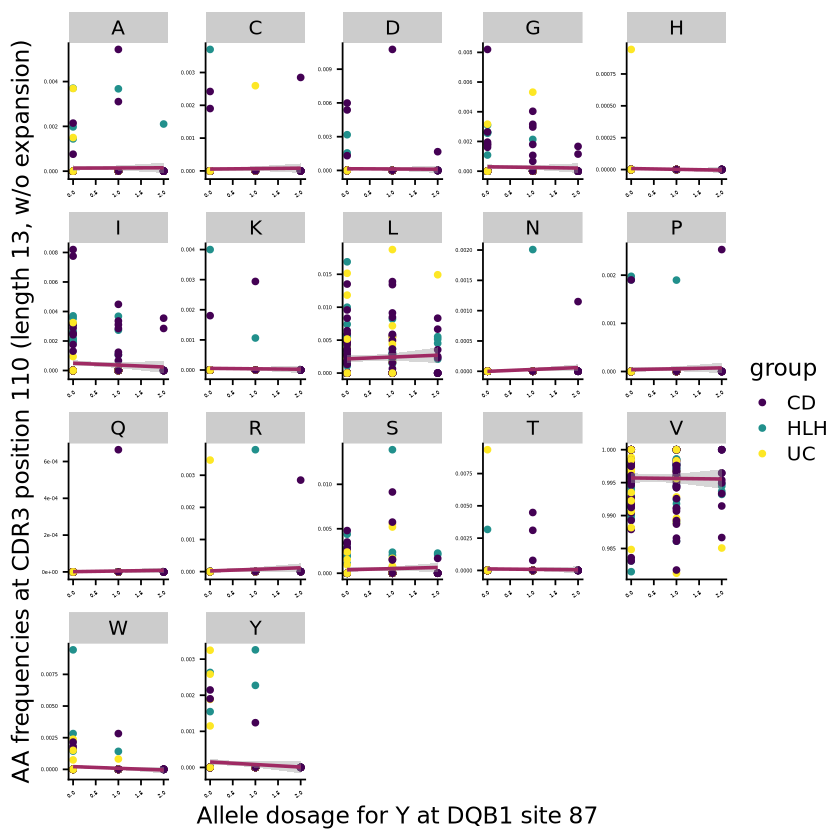

In [152]:
lm_plot <- ggplot(melt(pair_matrix %>% dplyr::select(patient_id, group, allele_E, any_of(amino_acids)), 
                                    id.vars = c('patient_id', 'allele_E', 'group')), 
                  aes(x = allele_E, y = value, colour = group)) +
    geom_point() +
    scale_color_viridis_d() +
    theme_cowplot()+
    stat_smooth(method = "lm", formula = 'y ~ x', color = '#9f2a63') + 
    facet_wrap(~variable, scales = 'free') +
    labs( x = 'Allele dosage for Y at DQB1 site 87', y = 'AA frequencies at CDR3 position 110 (length 13, w/o expansion)') +
    theme(axis.text.x = element_text(size = 3, angle = 35, hjust = 1),
        axis.text.y = element_text(size = 3))
lm_plot
#ggsave('../../plots/lm_plot_for_dqb1_87_13_p110_freq_allele_Y.png', lm_plot_drb1_13_13_p109) 

### Running conditional haplotype analysis on the background

In [ ]:
phenotype <- 'I'
hla_genes <- c('DQB1', 'DQA1', 'B', 'DPB1', 'DPA1', 'A', 'C')
hla_gene <- 'B'
cond_round <- 5
using_groups <- FALSE
source('/work_beegfs/sukmb667/projects/cdr3-qtl/healthy_and_ibd/scripts/R_scripts/Conditional_haplotype_on_combined_IKMB_data.r')

Warning message in mvlm(formula_full, cdr3_hla_matrix):
“Adjusted sample size = 67
Asymptotic properties of the null distribution may not hold.
This can result in overly conservative p-values.
Increased sample size is recommended.”
Warning message in mvlm(formula_null, cdr3_hla_matrix):
“Adjusted sample size = 67
Asymptotic properties of the null distribution may not hold.
This can result in overly conservative p-values.
Increased sample size is recommended.”
Warning message in mvlm(formula_full, cdr3_hla_matrix):
“Adjusted sample size = 73
Asymptotic properties of the null distribution may not hold.
This can result in overly conservative p-values.
Increased sample size is recommended.”
Warning message in mvlm(formula_null, cdr3_hla_matrix):
“Adjusted sample size = 74
Asymptotic properties of the null distribution may not hold.
This can result in overly conservative p-values.
Increased sample size is recommended.”
Warning message in mvlm(formula_full, cdr3_hla_matrix):
“Adjusted sample